In [1]:
import numpy as np
from numpy import random
import math
from matplotlib import pyplot as plt
from scipy import misc
import scipy

In [2]:
%cd ..
from rputil import *
%cd -

/mnt/c/Users/rishi/GitHub/icerm/random-projections
/mnt/c/Users/rishi/GitHub/icerm/random-projections/notebooks


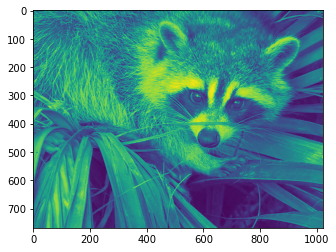

In [3]:
face = misc.face()
data = face[:,:,0] / 255
plt.imshow(data)

In [4]:
data.shape

(768, 1024)

In [5]:
m = 768 # number of data points
n = 1024 # dimensional of data
A = data # data matrix
l = 100 # dimension of low diml space

iterations = 20

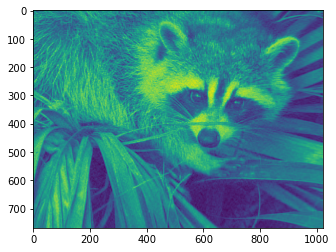

In [6]:
from sklearn.decomposition import PCA
pca = PCA(0.95)
approx = pca.inverse_transform(pca.fit_transform(data))
plt.imshow(approx)

Text(0.5, 0.98, 'Rank 10 Approximations')

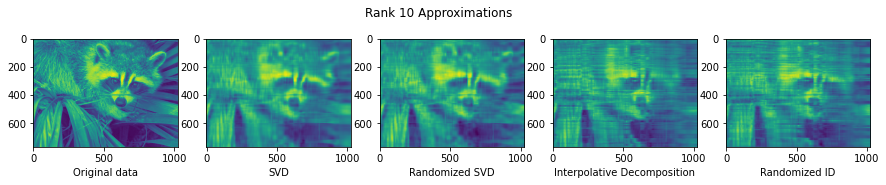

In [7]:
fig, ax = plt.subplots(1,5, figsize=(15,2.5))
ax[0].imshow(data)
ax[0].set_xlabel('Original data')
ax[1].imshow(svd_rank_k(data, 10))
ax[1].set_xlabel('SVD')
ax[2].imshow(random_svd_rank_k(data, 10))
ax[2].set_xlabel('Randomized SVD')
ax[3].imshow(id_rank_k(data, 10))
ax[3].set_xlabel('Interpolative Decomposition')
ax[4].imshow(random_id_rank_k(data, 10))
ax[4].set_xlabel('Randomized ID')
plt.suptitle('Rank 10 Approximations')

Text(0.5, 0.98, 'Rank 100 Approximations')

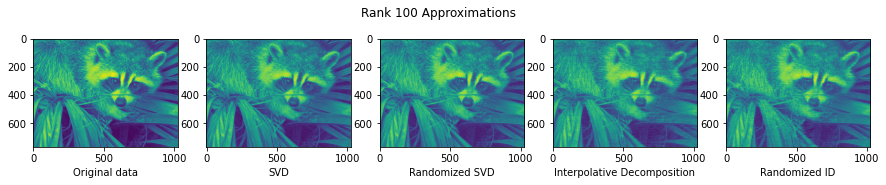

In [8]:
fig, ax = plt.subplots(1,5, figsize=(15,2.5))
ax[0].imshow(data)
ax[0].set_xlabel('Original data')
ax[1].imshow(svd_rank_k(data, 100))
ax[1].set_xlabel('SVD')
ax[2].imshow(random_svd_rank_k(data, 100))
ax[2].set_xlabel('Randomized SVD')
ax[3].imshow(id_rank_k(data, 100))
ax[3].set_xlabel('Interpolative Decomposition')
ax[4].imshow(random_id_rank_k(data, 100))
ax[4].set_xlabel('Randomized ID')
plt.suptitle('Rank 100 Approximations')

In [9]:
k_domain = np.array([8,16,32,64,128,256])
error_svd = np.empty(k_domain.shape[0])
error_id = np.empty(k_domain.shape[0])

for i,val in enumerate(k_domain):
    error_svd[i] = np.linalg.norm(data - svd_rank_k(data, val)) / np.linalg.norm(data)
    error_id[i] = np.linalg.norm(data - id_rank_k(data, val)) / np.linalg.norm(data)

error_random_svd = np.empty((7,k_domain.shape[0]))
error_random_id = np.empty((7, k_domain.shape[0]))

iterations = 10

for i,val in enumerate(k_domain):
    err_rsvd = np.empty(iterations)
    err_rid = np.empty(iterations)

    for j in range(iterations):
        err_rsvd[j] = np.linalg.norm(data - random_svd_rank_k(data, val)) / np.linalg.norm(data)
        err_rid[j] = np.linalg.norm(data - random_id_rank_k(data, val)) / np.linalg.norm(data)
    error_random_svd[0][i] = np.quantile(err_rsvd, 0.25)
    error_random_svd[1][i] = np.median(err_rsvd)
    error_random_svd[2][i] = np.quantile(err_rsvd, 0.75)
    error_random_svd[3][i] = np.mean(err_rsvd)
    error_random_svd[4][i] = np.std(err_rsvd)
    error_random_svd[5][i] = np.min(err_rsvd)
    error_random_svd[6][i] = np.max(err_rsvd)

    error_random_id[0][i] = np.quantile(err_rid, 0.25)
    error_random_id[1][i] = np.median(err_rid)
    error_random_id[2][i] = np.quantile(err_rid, 0.75)
    error_random_id[3][i] = np.mean(err_rid)
    error_random_id[4][i] = np.std(err_rid)
    error_random_id[5][i] = np.min(err_rid)
    error_random_id[6][i] = np.max(err_rid)


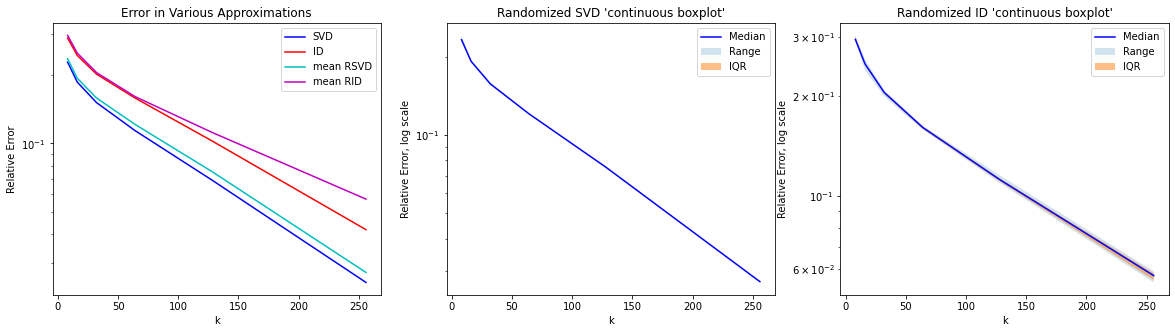

In [10]:
fig, ax = plt.subplots(1,3, figsize=(20,5))

ax[0].plot(k_domain, error_svd, c='b', label='SVD')
ax[0].plot(k_domain, error_id, c='r', label='ID')
ax[0].plot(k_domain, error_random_svd[3], c='c', label='mean RSVD')
ax[0].plot(k_domain, error_random_id[3], c='m', label='mean RID')
ax[0].set_xlabel('k')
ax[0].set_ylabel('Relative Error')
ax[0].set_yscale('log')
ax[0].legend(loc='upper right')
ax[0].set_title('Error in Various Approximations')

ax[1].plot(k_domain, error_random_svd[1], c='b', label='Median')
ax[1].fill_between(k_domain, error_random_svd[6],error_random_svd[5], alpha=0.2, label='Range')
ax[1].fill_between(k_domain, error_random_svd[2],error_random_svd[0], alpha=0.5, label='IQR')
ax[1].set_xlabel('k')
ax[1].set_ylabel('Relative Error, log scale')
ax[1].set_yscale('log')
ax[1].legend(loc='upper right')
ax[1].set_title('Randomized SVD \'continuous boxplot\'')

ax[2].plot(k_domain, error_random_id[1], c='b', label='Median')
ax[2].fill_between(k_domain, error_random_id[6],error_random_id[5], alpha=0.2, label='Range')
ax[2].fill_between(k_domain, error_random_id[2],error_random_id[0], alpha=0.5, label='IQR')
ax[2].set_xlabel('k')
ax[2].set_ylabel('Relative Error, log scale')
ax[2].set_yscale('log')
ax[2].legend(loc='upper right')
ax[2].set_title('Randomized ID \'continuous boxplot\'')

plt.show()